## Week 8

Tham khảo link: https://www.tensorflow.org/tutorials/audio/simple_audio

Để dự đoán âm thanh các chữ số: 1 - 9.

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import pydub

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'data/digits_number'
data_dir = pathlib.Path(DATASET_PATH)
print("Data directory:", data_dir)

# Inspect directory structure
for speaker in sorted(data_dir.glob('*')):
    print(speaker.name, "->", len(list(speaker.glob('*.wav'))), "files")

Data directory: data/digits_number
.DS_Store -> 0 files
eight -> 300 files
five -> 300 files
four -> 300 files
nine -> 300 files
one -> 300 files
seven -> 300 files
six -> 300 files
three -> 300 files
two -> 300 files
zero -> 300 files


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['eight' 'nine' 'three' 'one' 'zero' 'seven' 'two' 'six' 'five' 'four']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.

label names: ['eight' 'five' 'four' 'nine' 'one' 'seven' 'six' 'three' 'two' 'zero']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels


train_ds = train_ds.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(32, 16000)
(32,)


2025-11-07 10:30:41.029683: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
label_names[[1,1,3,0]]

array(['five', 'five', 'nine', 'eight'], dtype='<U5')

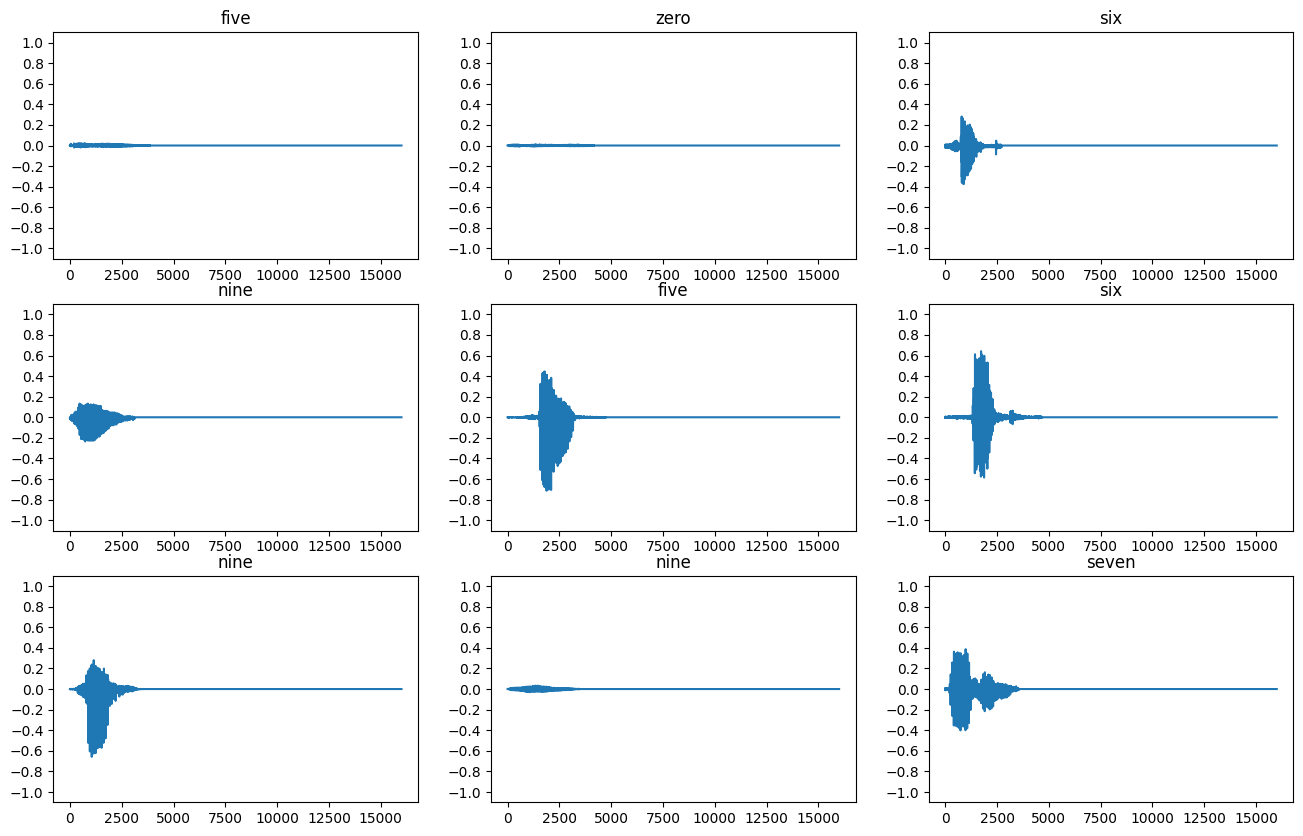

In [10]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [11]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [12]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform.numpy(), rate=16000))


Label: five
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: zero
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: six
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

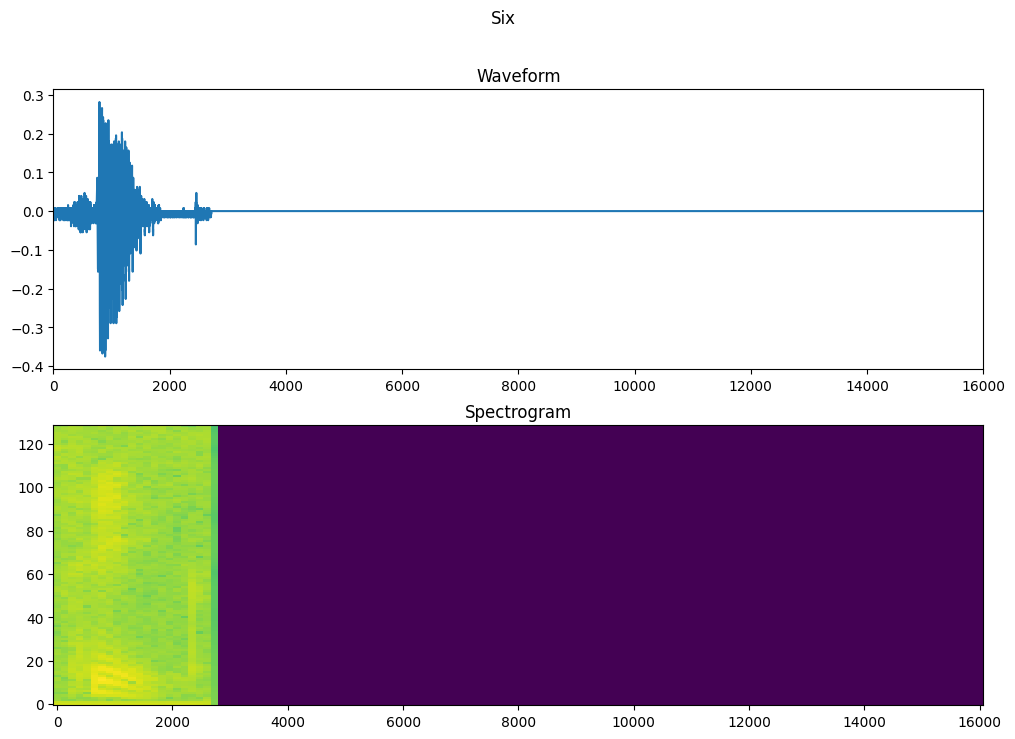

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [15]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [17]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

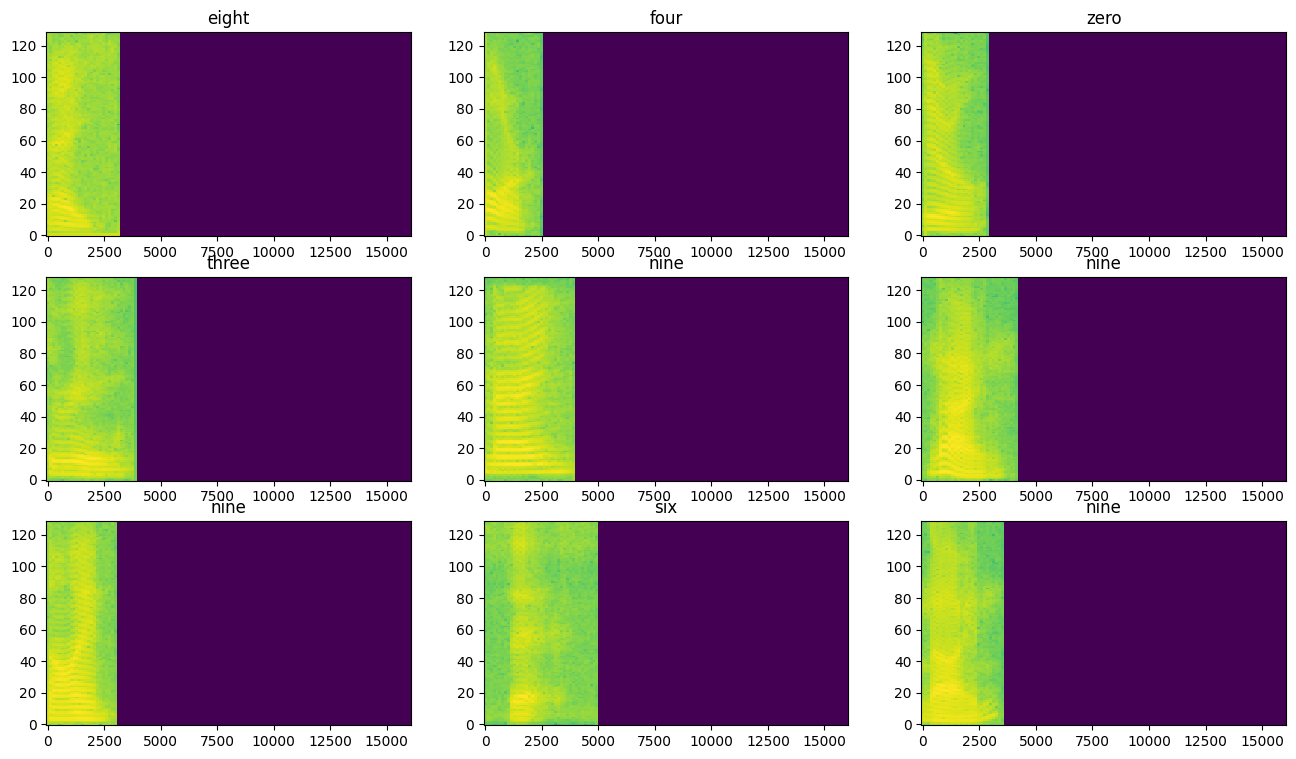

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [19]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [20]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()

small_ds = train_spectrogram_ds.take(500)  # use only 500 samples
norm_layer.adapt(data=small_ds.map(lambda spec, label: spec))


model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2025-11-07 10:30:42.968525: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [21]:
for spec, label in train_spectrogram_ds.take(1):
    print("Spectrogram:", spec[0].shape)
    print("Label:", label[0].numpy())

Spectrogram: (124, 129, 1)
Label: 6


In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [23]:
for spec, label in train_spectrogram_ds.take(1):
    print(spec.shape, label.shape)


(32, 124, 129, 1) (32,)


2025-11-07 10:30:43.100579: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS, 
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.3858 - loss: 1.7663 - val_accuracy: 0.6840 - val_loss: 1.0803
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5908 - loss: 1.2125 - val_accuracy: 0.7743 - val_loss: 0.7783
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6908 - loss: 0.9275 - val_accuracy: 0.8333 - val_loss: 0.5646
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7496 - loss: 0.7512 - val_accuracy: 0.8611 - val_loss: 0.4547
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.7908 - loss: 0.6315 - val_accuracy: 0.8715 - val_loss: 0.4198
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8233 - loss: 0.5306 - val_accuracy: 0.8924 - val_loss: 0.3264
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8517 - loss: 0.4470 - val_accuracy: 0.9167 - val_loss: 0.2899
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8667 - loss: 0.3929 - val_accuracy: 0.9340 - v

In [25]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


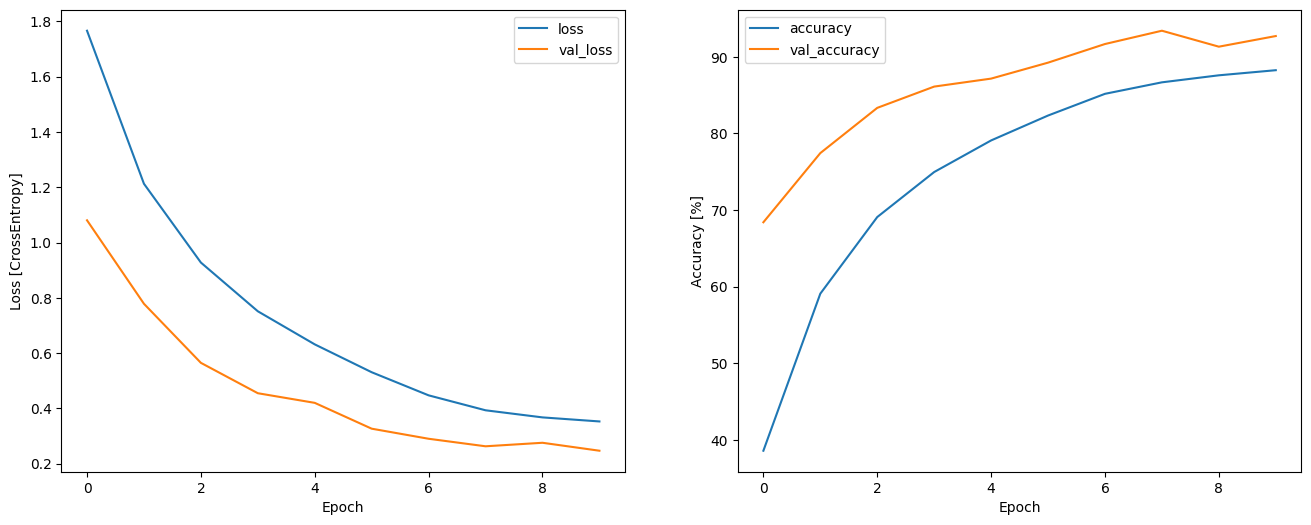

In [26]:
metrics = history.history
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(metrics['loss'], label='loss')
if 'val_loss' in metrics:
    plt.plot(metrics['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(100*np.array(metrics['accuracy']), label='accuracy')
if 'val_accuracy' in metrics:
    plt.plot(100*np.array(metrics['val_accuracy']), label='val_accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

In [27]:
model.evaluate(test_spectrogram_ds, return_dict=True)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9327 - loss: 0.2681 


{'accuracy': 0.932692289352417, 'loss': 0.2680707573890686}

In [28]:
y_pred = model.predict(test_spectrogram_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [29]:
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)

print("True shape:", y_true.shape)
print("Pred shape:", y_pred.shape)
print("Sample true:", y_true[:10].numpy())
print("Sample pred:", y_pred[:10].numpy())

# Get raw predictions
y_pred_logits = model.predict(test_spectrogram_ds)
print("Sample logits:\n", y_pred_logits[:10])

True shape: (312,)
Pred shape: (312,)
Sample true: [6 2 4 8 1 1 2 1 1 2]
Sample pred: [6 2 4 8 1 1 2 1 1 2]
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Sample logits:
 [[  5.1388464   -7.358557    -9.683365    -7.1017594   -1.7447951
    0.29876113  12.637846    -0.2833633   -8.23562     -7.122692  ]
 [-11.190677     5.2423177   16.540482    -8.689516     4.9065228
   -3.8289328   -9.126653   -11.049253   -10.889305    -7.83041   ]
 [-12.159525     5.345588     4.353901     3.1749175    9.392067
   -3.8452578   -8.516185    -9.020984    -7.695479    -8.243193  ]
 [ -3.677311    -3.2881942   -3.2738647   -1.935303    -2.1706514
   -1.4480686   -1.014262     2.5905592    3.8872707    0.84355074]
 [ -7.894388     5.7208724   -0.1330545    4.2814646   -3.594264
   -0.96633905  -3.8464913   -4.8018723   -7.2653756    0.44350845]
 [-15.114606     6.8188157   -4.4202228    6.648611     4.8312583
   -1.6931545   -9.51864      0.38148648  -4.6757436   -4.233453  ]
 [-13.77135      0.34859312  17.901

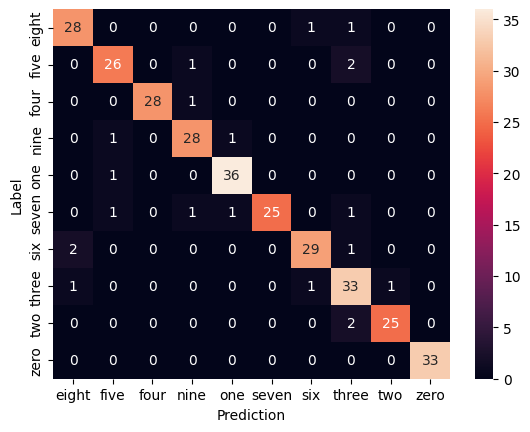

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()